<a href="https://colab.research.google.com/github/maruwrks/Deep-Learning-Task/blob/main/robust_scaler_sama_dibagi_perbatch_(lama_banget).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Robust

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Multiply, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
import gc
import joblib
from tqdm import tqdm
import os

## Data Preperation

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

In [11]:
def load_data_in_batches(file_path, chunksize=10000):
    chunks = []
    for chunk in tqdm(pd.read_csv(file_path, chunksize=chunksize, low_memory=False)):
        chunks.append(chunk)
    return pd.concat(chunks, axis=0)


In [12]:
df = pd.read_csv('C:/Users/Maru/Documents/RegresiUTSTelkom.csv', low_memory=False)
df.shape

(515344, 91)

In [13]:
df.describe()

,2001,49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.0162,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
count,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,...,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000
mean,1998.397077,43.387113,1.289515,8.658222,1.164110,-6.553580,-9.521968,-2.391046,-1.793215,3.727868,...,15.755411,-73.461537,41.542388,37.934163,0.315750,17.669292,-26.315520,4.458653,20.035229,1.329104
std,10.931056,6.067557,51.580393,35.268505,16.322802,22.860803,12.857763,14.571853,7.963822,10.582869,...,32.099666,175.619058,122.228915,95.050718,16.161780,114.428002,173.977455,13.346567,185.558415,22.088598
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954667,-26.059848,-11.462775,-8.487507,-20.666455,-18.441005,-10.780360,-6.468390,-2.293670,...,-1.812658,-139.555737,-20.987115,-4.669655,-6.781598,-31.580617,-101.530305,-2.566137,-59.509453,-8.820248
50%,2002.000000,44.258490,8.417725,10.476235,-0.652855,-6.007770,-11.188355,-2.046625,-1.736415,3.822305,...,9.171850,-53.089115,28.790580,33.623815,0.820830,15.598520,-21.204225,3.117645,7.759910,0.053015
75%,2006.000000,47.833875,36.124030,29.764685,8.787548,7.741877,-2.388945,6.508587,2.913455,9.961865,...,26.274487,13.478793,89.661785,77.785810,8.471000,67.795110,52.389322,9.967742,86.351645,9.679540
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


In [14]:
df = df.dropna()

In [15]:
target_col = df.columns[0]

## Preprocessing

In [16]:
def clean_data_in_batches(df, target_col):
    df = df.dropna()

    Q1 = df[target_col].quantile(0.05)
    Q3 = df[target_col].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    return df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)]


In [17]:
df_clean = clean_data_in_batches(df, target_col)

In [18]:
def create_features(df, target_col):
    df_new = df.copy()
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != target_col]

    new_features = []

    for col in numeric_cols:
        col_feats = {}
        series = df[col]

        if (series > 0).all():
            col_feats[f'log_{col}'] = np.log1p(series)
        if (series >= 0).all():
            col_feats[f'sqrt_{col}'] = np.sqrt(series)

        col_feats[f'{col}_squared'] = series ** 2
        col_feats[f'{col}_cubed'] = series ** 3

        if len(df) > 100:
            col_feats[f'{col}_rolling_mean_5'] = series.rolling(5).mean().fillna(0)
            col_feats[f'{col}_rolling_std_5'] = series.rolling(5).std().fillna(0)

        new_features.append(pd.DataFrame(col_feats))

    df_all_new = pd.concat([df_new] + new_features, axis=1)
    return df_all_new

In [19]:
def create_features_batch(df, target_col, batch_size=10000, temp_dir='/content/temp_batches'):
    os.makedirs(temp_dir, exist_ok=True)
    temp_files = []

    for i in tqdm(range(0, len(df), batch_size)):
        batch = df.iloc[i:i+batch_size].copy()
        batch_feat = create_features(batch, target_col)
        temp_path = os.path.join(temp_dir, f'batch_{i}.csv')
        batch_feat.to_csv(temp_path, index=False)
        temp_files.append(temp_path)
        del batch, batch_feat
        gc.collect()

    # Load all processed batches
    final_df = pd.concat((pd.read_csv(f) for f in temp_files), axis=0)

    # Optionally clean up temp files
    for f in temp_files:
        os.remove(f)

    return final_df

In [20]:
df_engineered = create_features_batch(df_clean, target_col)

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [06:34<00:00,  7.58s/it]


In [21]:
def mutual_info_batch(X, y, batch_size=5000, n_features_to_keep=20):
    feature_scores = pd.Series(0, index=X.columns)

    for _ in tqdm(range(3)):  # Run multiple passes for stability
        sample_idx = np.random.choice(len(X), min(batch_size, len(X)), replace=False)
        X_sample = X.iloc[sample_idx]
        y_sample = y.iloc[sample_idx]

        mi = mutual_info_regression(X_sample, y_sample)
        feature_scores += pd.Series(mi, index=X.columns)

    # Return top features
    return feature_scores.nlargest(n_features_to_keep).index.tolist()

In [22]:
X = df_engineered.drop(target_col, axis=1)
y = df_engineered[target_col]

In [23]:
selected_features = mutual_info_batch(X, y)
print(f"Selected features: {selected_features}")

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:46<00:00, 15.46s/it]

Selected features: ['49.94357_squared', '49.94357_cubed', '49.94357', 'log_49.94357', 'sqrt_49.94357', '49.94357_rolling_mean_5', '-13.09905_cubed', '-13.09905', '-13.09905_rolling_mean_5', '-10.7366_rolling_mean_5', '21.47114_rolling_mean_5', '-0.36994_rolling_mean_5', '82.15479_cubed', '-10.7366', '4.69525_rolling_mean_5', '-18.60478_cubed', '26.08481_rolling_mean_5', '-8.41558_rolling_std_5', '28.09139', '-18.60478_rolling_mean_5']


In [24]:
X = X[selected_features]

In [25]:
scaler = RobustScaler()
scaler.fit(X)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [26]:
def scale_in_batches(X, scaler, batch_size=10000):
    """Scale data in batches"""
    X_scaled = np.zeros(X.shape, dtype=np.float32)
    for i in tqdm(range(0, len(X), batch_size)):
        X_scaled[i:i+batch_size] = scaler.transform(X.iloc[i:i+batch_size])
    return X_scaled


In [27]:
X_scaled = scale_in_batches(X, scaler)

100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 376.44it/s]


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y.values,test_size=0.2,random_state=42)

## Modeling

In [29]:
def create_batch_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = create_batch_dataset(X_train, y_train)
test_ds = create_batch_dataset(X_test, y_test, shuffle=False)


In [30]:
def build_improved_model(input_dim):
    inputs = Input(shape=(input_dim,))

    # Feature attention mechanism
    attention = Dense(input_dim, activation='softmax')(inputs)
    attended_features = Multiply()([inputs, attention])

    # Main network with residual connection
    x = Dense(256, activation='swish', kernel_initializer='he_normal')(attended_features)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation='swish', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='swish', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Residual connection if dimensions match
    if input_dim == 64:
        shortcut = Dense(64, activation='linear')(attended_features)
        x = Add()([x, shortcut])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [31]:
input_dim = X_train.shape[1]
model = build_improved_model(input_dim)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 20)           420         ['input_1[0][0]']                
                                                                                                  
 multiply (Multiply)            (None, 20)           0           ['input_1[0][0]',                
                                                                  'dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 256)          5376        ['multiply[0][0]']           

In [32]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, min_delta=0.001),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

In [33]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae']
)

In [34]:
gc.collect()

323

In [35]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50
3221/3221 [==============================] - 56s 16ms/step - loss: 1506.6302 - root_mean_squared_error: 1564.9604 - mae: 1507.1301 - val_loss: 644.1320 - val_root_mean_squared_error: 647.0151 - val_mae: 644.6320 - lr: 0.0010
Epoch 2/50
3221/3221 [==============================] - 51s 16ms/step - loss: 154.0020 - root_mean_squared_error: 214.9348 - mae: 154.5011 - val_loss: 13.3716 - val_root_mean_squared_error: 15.3829 - val_mae: 13.8684 - lr: 0.0010
Epoch 3/50
3221/3221 [==============================] - 52s 16ms/step - loss: 99.8418 - root_mean_squared_error: 125.9868 - mae: 100.3409 - val_loss: 17.5282 - val_root_mean_squared_error: 19.9657 - val_mae: 18.0257 - lr: 0.0010
Epoch 4/50
3221/3221 [==============================] - 52s 16ms/step - loss: 99.4710 - root_mean_squared_error: 125.5161 - mae: 99.9701 - val_loss: 15.2613 - val_root_mean_squared_error: 17.3678 - val_mae: 15.7587 - lr: 0.0010
Epoch 5/50
3221/3221 [==============================] - 51s 16ms/step - loss:

## Evaluation

In [40]:
def improved_evaluation(model_obj, model_name, X_test, y_test, use_log_target=False):
    # Get predictions
    y_pred_log = model_obj.predict(X_test).flatten()

    # Transform back if log was used
    if use_log_target:
        y_pred = np.expm1(y_pred_log)
        y_true = np.expm1(y_test)
    else:
        y_pred = y_pred_log
        y_true = y_test

    # Calculate metrics
    metrics = {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100  # Avoid division by zero
    }

    print(f"\n=== {model_name} Evaluation ===")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    # Feature importance analysis
    if hasattr(model_obj, 'layers'):
        weights = model_obj.layers[1].get_weights()[0]  # First dense layer weights
        importance = np.mean(np.abs(weights), axis=1)
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importance
        }).sort_values('Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
        plt.title('Top 20 Feature Importances')
        plt.show()

    # Enhanced visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Actual vs Predicted
    sns.scatterplot(x=y_true, y=y_pred, ax=axes[0, 0], alpha=0.6)
    axes[0, 0].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    axes[0, 0].set_title('Actual vs Predicted')
    axes[0, 0].set_xlabel('Actual')
    axes[0, 0].set_ylabel('Predicted')

    # Residuals plot
    residuals = y_true - y_pred
    sns.scatterplot(x=y_pred, y=residuals, ax=axes[0, 1], alpha=0.6)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_title('Residuals Plot')
    axes[0, 1].set_xlabel('Predicted Values')
    axes[0, 1].set_ylabel('Residuals')

    # Error distribution
    sns.histplot(residuals, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Error Distribution')
    axes[1, 0].set_xlabel('Error')

    # Learning curve
    if hasattr(model_obj, 'history'):
        history_df = pd.DataFrame(model_obj.history.history)
        # Convert columns to numeric if possible
        for col in history_df.columns:
            try:
                # Attempt to convert the column to numeric
                history_df[col] = pd.to_numeric(history_df[col])
            except ValueError:
                print(f"Warning: Column '{col}' could not be converted to numeric and will be excluded from the plot.")

        # Select only numeric columns for plotting
        numeric_cols = history_df.select_dtypes(include=np.number).columns
        # Check if there are any numeric columns to plot
        if len(numeric_cols) > 0:
            history_df[numeric_cols].plot(ax=axes[1, 1])
            axes[1, 1].set_title('Learning Curve')
        else:
            print("Warning: No numeric columns found in training history. Skipping learning curve plot.")


    return metrics

3221/3221 [==============================] - 10s 3ms/step

=== Improved MLP Model Evaluation ===
MSE: 236.6349
RMSE: 15.3829
MAE: 13.8684
R2: -0.9938
MAPE: 0.6934


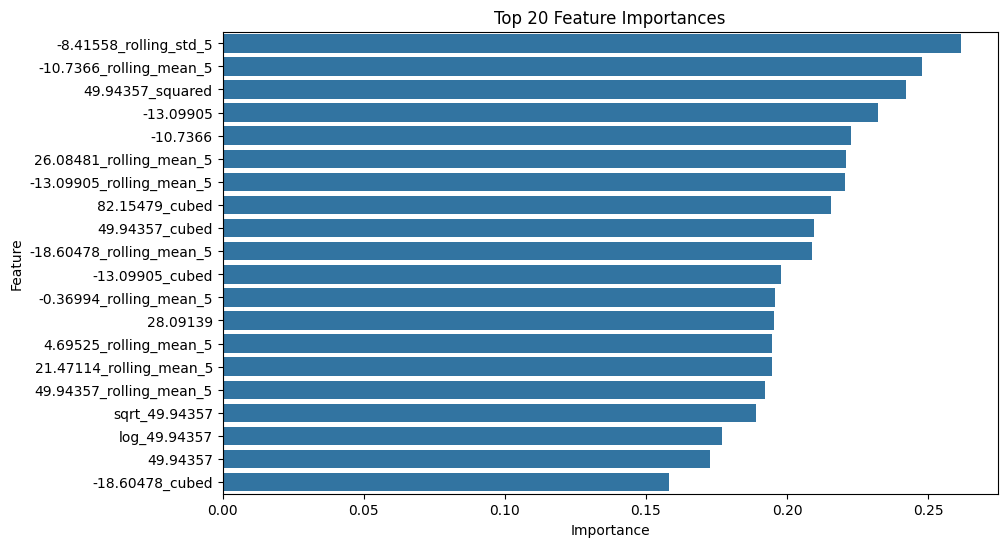

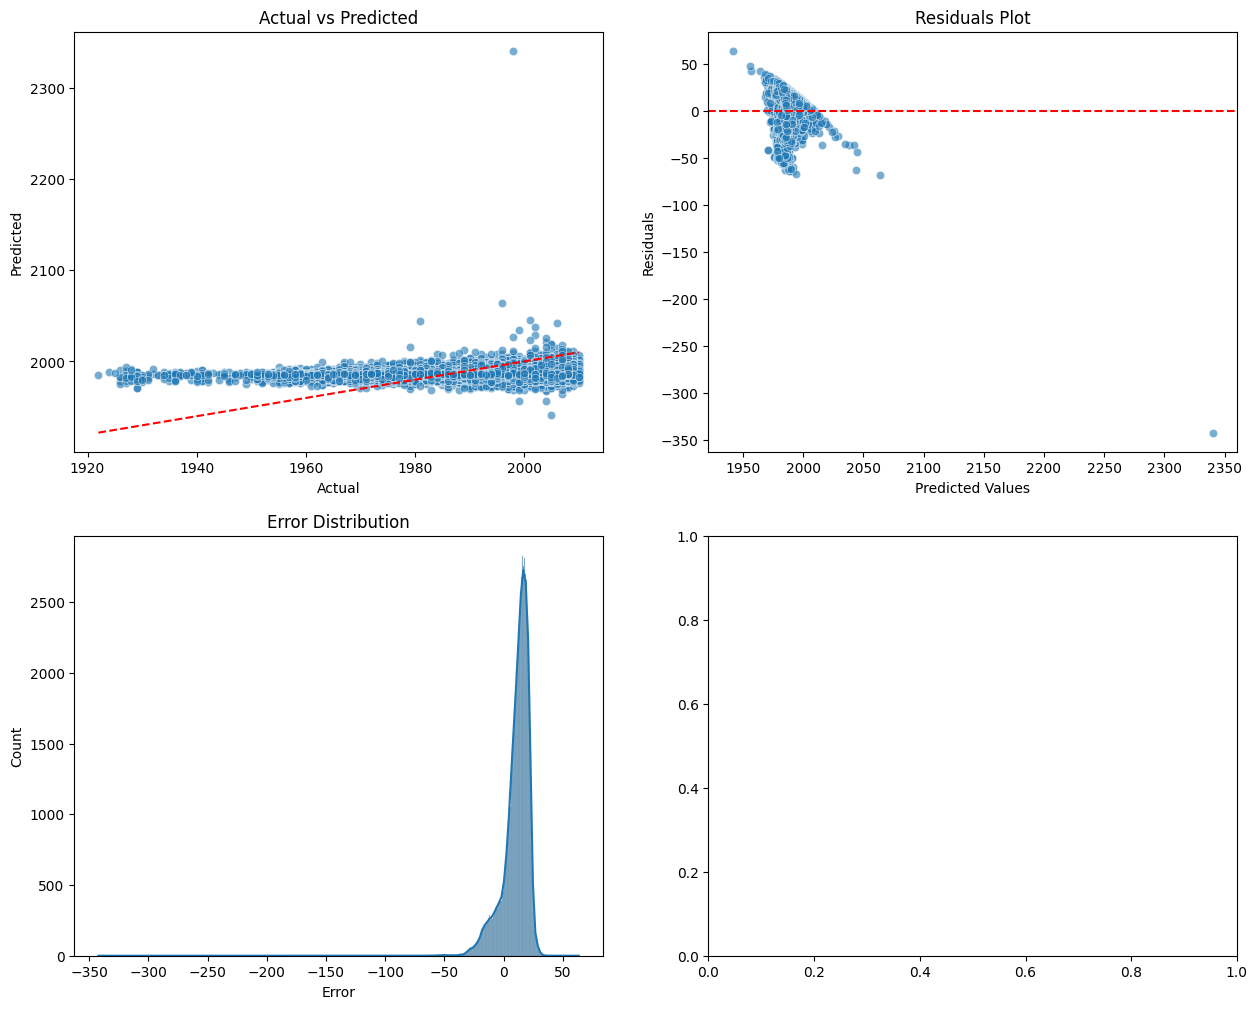

In [41]:
metrics = improved_evaluation(model, "Improved MLP Model", X_test, y_test, use_log_target=False)